# Happy-or-sad binary classification with CNN and Automatic feature labelling

* Building a convolutional neural network for binary classification of images.
* Labelling the data set automatically using ImageDataGenerator in Keras.
* 80 training set (40 for happy, 40 for sad)
* Visualization of feature maps on convolution and pooling layers.

Train a CNN
1. 16 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
1. 32 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
1. 64 x 3 x 3 convolution layer
2. 2 x 2 max pooling layer
3. 512-neurons hidden layer (ReLU)
4. output layer (sigmoid)

Optimizer: RMSprop with learning rate = 0.001

Loss function: binary cross-entropy

## Download images for happy or sad faces

In [1]:
# Training set
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip \
    -O ~/Downloads/happy-or-sad.zip

--2019-07-24 21:26:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.192.240
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.192.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/Users/johanzhuohan/Downloads/happy-or-sad.zip’

/Users/johanzhuohan 100%[===================>]   2.55M  5.57MB/s    in 0.5s    

2019-07-24 21:26:52 (5.57 MB/s) - ‘/Users/johanzhuohan/Downloads/happy-or-sad.zip’ saved [2670333/2670333]



* Unzipping to two directories for training and validation set, respectively.

In [2]:
import zipfile

# Training set
local_zip = '/Users/johanzhuohan/Downloads/happy-or-sad.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Users/johanzhuohan/Downloads/happy-or-sad')

zip_ref.close()

In [3]:
import os

# Directory with training happy pictures
train_happy_dir = os.path.join('/Users/johanzhuohan/Downloads/happy-or-sad/happy')
# File names
train_happy_names = os.listdir(train_happy_dir)

# Directory with training sad pictures
train_sad_dir = os.path.join('/Users/johanzhuohan/Downloads/happy-or-sad/sad')
# File names
train_sad_names = os.listdir(train_sad_dir)

## Training a Convolutional neural network

In [4]:
import tensorflow as tf

* Set callbacks with accuracy of 99.9%

In [5]:
DESIRED_ACCURACY = 0.998
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>DESIRED_ACCURACY):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

* Bulding the CNN model: 3 convolution+maxpooling + 1 hidden layer + 1 output layer

In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flattening the 2d array to the 1d array
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

* Set the optimizer and the loss function
* Try 'sgd', or 'Adam' for optimizer

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

* Data processing with ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/Users/johanzhuohan/Downloads/happy-or-sad',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 80 images belonging to 2 classes.


* Training with callbacks

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  # = Number of training data / batch_size
      epochs=15,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/15
8/8 [==============================] - 4s 449ms/step - loss: 3.2485 - acc: 0.6375
Epoch 2/15
8/8 [==============================] - 3s 313ms/step - loss: 0.4809 - acc: 0.7375

## Visualizing convoluted images

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


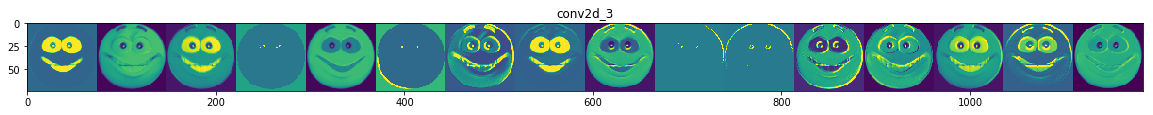

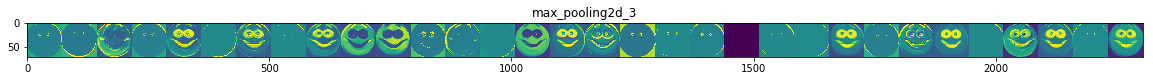

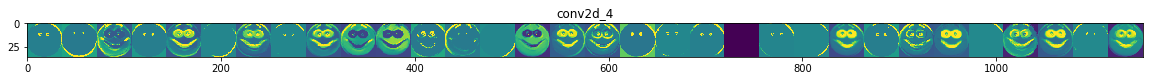

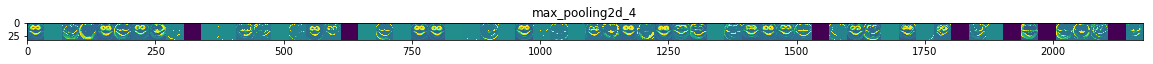

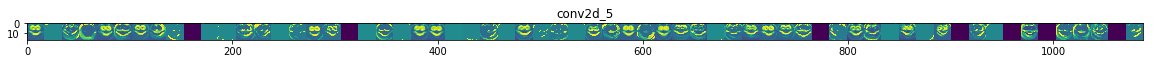

In [12]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt


successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# randomly choosing an example image from training data set
happy_img_files = [os.path.join(train_happy_dir, f) for f in train_happy_names]
sad_img_files = [os.path.join(train_sad_dir, f) for f in train_sad_names]
img_path = random.choice(happy_img_files + sad_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image, RGB mode (3 channel)
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
x /= 255 # Rescale by 1/255

# successive layers for data x
successive_feature_maps = visualization_model.predict(x)
# name of layers
layer_names = [layer.name for layer in model.layers]

# Plot
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in feature map
        size = feature_map.shape[1] # size of pictures, The feature map has shape (1, size, size, n_features)
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean() # normalization
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8') # set lower (0) and upper (255) limit on the value
            display_grid[:, i * size : (i + 1) * size] = x
            
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')     
plt.show()